# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10,10), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 73772437.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21798757.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25603886.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17904632.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [7]:
# importing the model from the model.py
from model import Net

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 4, 24, 24]             144
       BatchNorm2d-5            [-1, 4, 24, 24]               8
              ReLU-6            [-1, 4, 24, 24]               0
            Conv2d-7            [-1, 4, 22, 22]             144
       BatchNorm2d-8            [-1, 4, 22, 22]               8
              ReLU-9            [-1, 4, 22, 22]               0
          Dropout-10            [-1, 4, 22, 22]               0
        MaxPool2d-11            [-1, 4, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]              32
      BatchNorm2d-13            [-1, 8, 11, 11]              16
             ReLU-14            [-1, 8,

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:

model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 4, 24, 24]             144
       BatchNorm2d-5            [-1, 4, 24, 24]               8
              ReLU-6            [-1, 4, 24, 24]               0
            Conv2d-7            [-1, 4, 22, 22]             144
       BatchNorm2d-8            [-1, 4, 22, 22]               8
              ReLU-9            [-1, 4, 22, 22]               0
          Dropout-10            [-1, 4, 22, 22]               0
        MaxPool2d-11            [-1, 4, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]              32
      BatchNorm2d-13            [-1, 8, 11, 11]              16
             ReLU-14            [-1, 8,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Let's Train and test our model

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=0.0747 Batch_id=468 Accuracy=89.08: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0721, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Train: Loss=0.1454 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]



Test set: Average loss: 0.0522, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Train: Loss=0.0475 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]



Test set: Average loss: 0.0522, Accuracy: 9834/10000 (98.34%)

EPOCH: 3


Train: Loss=0.0945 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Train: Loss=0.0245 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0308, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Train: Loss=0.0538 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0377, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Train: Loss=0.0256 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]



Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Train: Loss=0.0579 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]



Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Train: Loss=0.0017 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:23<00:00, 19.64it/s]



Test set: Average loss: 0.0283, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Train: Loss=0.0136 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]



Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Train: Loss=0.0833 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0322, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Train: Loss=0.0115 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0279, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Train: Loss=0.0331 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Train: Loss=0.0455 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]



Test set: Average loss: 0.0242, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Train: Loss=0.1316 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)



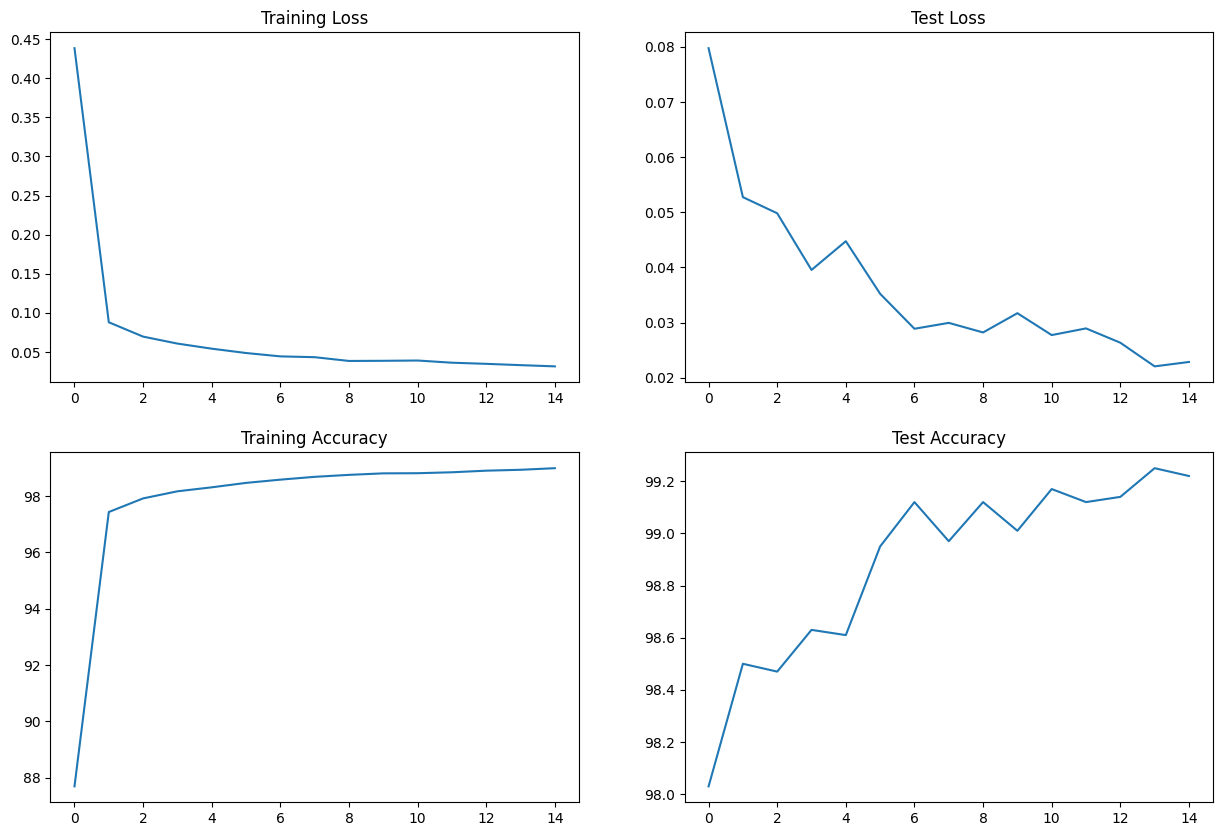

In [11]:
# Display the loss and accuracy in tranining and Test Data.
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)

## Model 1



Model Name : Net1

*Test Accuracy =  99.3% (max)

*Train Accuracy = 99.7%

*Total params: 15,580

Analysis:
1. Model is overfitting.
2. Number of parameter is less though but model can perform better.
3. Added one more convolution layer
4. changed the number of channels on the model

Model 2

Model name : Net
Results:


*   Best Train Accuracy: 98.99%
*   Best Test Accuracy: 99.26%
*   Parameters: 7,596

Analysis:
1. Updating the Image augmentation to check the impact on model accuracy.
2. Model is Underfitting.
